# Notebook 5: Phase 3 K-Means Optimization

**Goals:**
- Use K-Means to cluster countries based on economic/energy profile.
- **Strategy**: Divide & Conquer. Train specialized models for each cluster.
- **Models**: Linear Regression (Panel) AND XGBoost (Panel).
- **Evaluation**: Compare Global Model vs Cluster-specific Models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('../src')))
from preprocessing import load_data

SPLIT_YEAR = 2015
TARGET = 'Value_co2_emissions_kt_by_country'

# Load Data
df_common = load_data('../data/processed/common_preprocessed.csv')
df_lr = load_data('../data/processed/lr_final_prep.csv')
df_xgb = load_data('../data/processed/xgb_final_prep.csv')

# Align indices for LR
common_idx_lr = df_common.index.intersection(df_lr.index)
df_lr = df_lr.loc[common_idx_lr]

# Align indices for XGB
common_idx_xgb = df_common.index.intersection(df_xgb.index)
df_xgb = df_xgb.loc[common_idx_xgb]

# Restore Year column if missing (Crucial for Split)
if 'Year' not in df_lr.columns:
    df_lr['Year'] = df_common.loc[df_lr.index, 'Year']
if 'Year' not in df_xgb.columns:
    df_xgb['Year'] = df_common.loc[df_xgb.index, 'Year']

Loaded data from ../data/processed/common_preprocessed.csv: (3473, 25)
Loaded data from ../data/processed/lr_final_prep.csv: (2190, 193)
Loaded data from ../data/processed/xgb_final_prep.csv: (3473, 25)


## 1. Clustering Analysis
We cluster countries based on their *average* characteristics over time (Development Level).
**IMPORTANT:** To avoid Data Leakage, we must calculate these profiles using **Training Data Only** (< 2015).

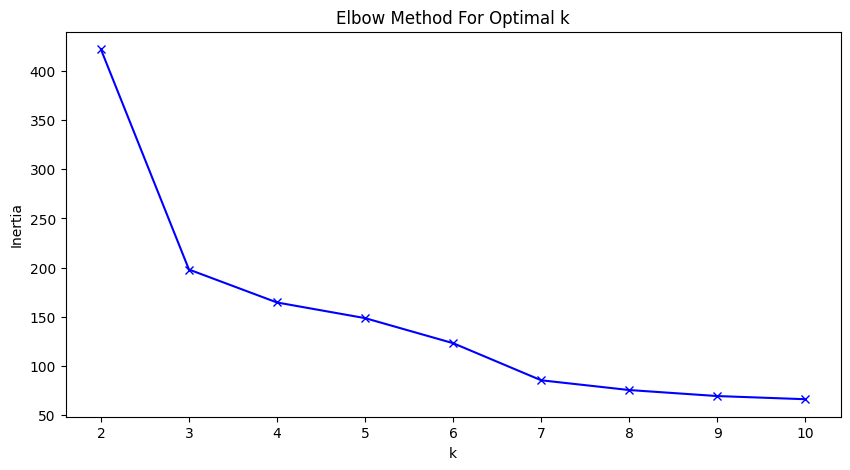

In [2]:
# Select features accurately representing a country's profile
cluster_cols = [
    'gdp_per_capita',
    'Access to electricity (% of population)',
    'Renewable energy share in the total final energy consumption (%)',
    'Primary energy consumption per capita (kWh/person)'
]

# Aggregate by Entity (Mean) - STRICTLY TRAINING DATA ONLY (< SPLIT_YEAR)
df_profile = df_common[df_common['Year'] < SPLIT_YEAR].groupby('Entity')[cluster_cols].mean().dropna()

# Scale for K-Means
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_profile)

# Elbow Method to find K (Manual implementation)
inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_cluster)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [3]:
# Apply K-Means (Using K=3 for simplicity: Underdeveloped, Developing, Developed)
best_k = 3 
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_profile['Cluster'] = kmeans.fit_predict(X_cluster)

# Inspect Clusters
print("Cluster Centers (Scaled):")
print(df_profile.groupby('Cluster').mean())

# Map Cluster back to Main Data
cluster_map = df_profile['Cluster']
df_common['Cluster'] = df_common['Entity'].map(cluster_map)

# Assign Clusters to LR and XGB data
# Since we aligned indices, we can map via df_common['Cluster'] using original Entity or index
# Safer: Index map
df_lr['Cluster'] = df_common.loc[df_lr.index, 'Cluster']
df_xgb['Cluster'] = df_common.loc[df_xgb.index, 'Cluster']

# Drop rows where Cluster is NaN (Entities dropped during profile creation due to missing data)
df_lr.dropna(subset=['Cluster'], inplace=True)
df_xgb.dropna(subset=['Cluster'], inplace=True)

print(f"Final LR Data with Clusters: {df_lr.shape}")
print(f"Final XGB Data with Clusters: {df_xgb.shape}")

Cluster Centers (Scaled):
         gdp_per_capita  Access to electricity (% of population)  \
Cluster                                                            
0           6970.978968                                93.574427   
1          43721.355893                                99.952873   
2           1481.460603                                32.899115   

         Renewable energy share in the total final energy consumption (%)  \
Cluster                                                                     
0                                                18.952500                  
1                                                12.491875                  
2                                                70.594132                  

         Primary energy consumption per capita (kWh/person)  
Cluster                                                      
0                                             19188.018054   
1                                             81933.454513   

## 2. Model Training & Evaluation
We compare Global vs Local Models for both LR and XGBoost.

In [4]:
# Initialize Results List
results = []

def eval_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return r2, rmse

def prepare_data(df, year_col='Year'):
    # Ensure Year col exists for split
    if year_col not in df.columns:
        print("Error: Year column missing!")
        return None, None, None, None, 0
        
    train = df[df[year_col] < SPLIT_YEAR]
    test = df[df[year_col] >= SPLIT_YEAR]
    
    if len(train) == 0 or len(test) == 0:
        return None, None, None, None, 0
        
    drop_cols = [TARGET, year_col, 'Cluster']
    drop_cols = [c for c in drop_cols if c in df.columns]
    
    X_train = train.drop(columns=drop_cols)
    y_train = train[TARGET]
    X_test = test.drop(columns=drop_cols)
    y_test = test[TARGET]
    
    return X_train, y_train, X_test, y_test, len(test)

# ============================
# 1. Linear Regression (Panel)
# ============================
print("\n=== Linear Regression (Panel) ===")

# Global LR
X_tr, y_tr, X_te, y_te, n = prepare_data(df_lr)
if n > 0:
    r2, rmse = eval_model(Ridge(alpha=1.0), X_tr, y_tr, X_te, y_te)
    r2_global_lr = r2
    print(f"Global LR: R2 = {r2:.4f}")

# Cluster LR
weighted_r2_lr = 0
total_n_lr = 0

for c in sorted(df_lr['Cluster'].unique()):
    data_c = df_lr[df_lr['Cluster'] == c].copy()
    X_tr, y_tr, X_te, y_te, n = prepare_data(data_c)
    
    if n > 0:
        r2, rmse = eval_model(Ridge(alpha=1.0), X_tr, y_tr, X_te, y_te)
        weighted_r2_lr += r2 * n
        total_n_lr += n
        print(f"Cluster {int(c)} LR: R2 = {r2:.4f}, RMSE = {rmse:.2f}")
        results.append({
            'Algorithm': 'Linear Regression (Panel)',
            'Cluster': c,
            'R2': r2,
            'RMSE': rmse,
            'Samples': n
        })

if total_n_lr > 0:
    avg_r2_lr = weighted_r2_lr / total_n_lr
    results.append({
        'Algorithm': 'Linear Regression (Panel)',
        'Cluster': 'Weighted_Avg',
        'R2': avg_r2_lr,
        'RMSE': np.nan,
        'Samples': total_n_lr
    })
    print(f"Weighted Avg LR: {avg_r2_lr:.4f}")

# ============================
# 2. XGBoost (Panel)
# ============================
print("\n=== XGBoost (Panel) ===")

# Global XGB
X_tr, y_tr, X_te, y_te, n = prepare_data(df_xgb)
if n > 0:
    r2, rmse = eval_model(XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1), X_tr, y_tr, X_te, y_te)
    r2_global_xgb = r2
    print(f"Global XGB: R2 = {r2:.4f}")

# Cluster XGB
weighted_r2_xgb = 0
total_n_xgb = 0

for c in sorted(df_xgb['Cluster'].unique()):
    data_c = df_xgb[df_xgb['Cluster'] == c].copy()
    X_tr, y_tr, X_te, y_te, n = prepare_data(data_c)
    
    if n > 0:
        r2, rmse = eval_model(XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1), X_tr, y_tr, X_te, y_te)
        weighted_r2_xgb += r2 * n
        total_n_xgb += n
        print(f"Cluster {int(c)} XGB: R2 = {r2:.4f}, RMSE = {rmse:.2f}")
        results.append({
            'Algorithm': 'XGBoost (Panel)',
            'Cluster': c,
            'R2': r2,
            'RMSE': rmse,
            'Samples': n
        })

if total_n_xgb > 0:
    avg_r2_xgb = weighted_r2_xgb / total_n_xgb
    results.append({
        'Algorithm': 'XGBoost (Panel)',
        'Cluster': 'Weighted_Avg',
        'R2': avg_r2_xgb,
        'RMSE': np.nan,
        'Samples': total_n_xgb
    })
    print(f"Weighted Avg XGB: {avg_r2_xgb:.4f}")


=== Linear Regression (Panel) ===


Global LR: R2 = 0.9772
Cluster 0 LR: R2 = 0.9789, RMSE = 6013.44
Cluster 1 LR: R2 = 0.9932, RMSE = 3095.30
Cluster 2 LR: R2 = 0.8977, RMSE = 5884.24
Weighted Avg LR: 0.9560

=== XGBoost (Panel) ===


Global XGB: R2 = 0.7415


Cluster 0 XGB: R2 = 0.8015, RMSE = 440883.56


Cluster 1 XGB: R2 = 0.7714, RMSE = 379431.53


Cluster 2 XGB: R2 = 0.7624, RMSE = 8394.21
Weighted Avg XGB: 0.7846


In [5]:
# Save Results
summary_df = pd.DataFrame(results)
summary_df.to_csv('../data/results/phase3_kmeans_results.csv', index=False)
print("\nSaved optimization results to phase3_kmeans_results.csv")


Saved optimization results to phase3_kmeans_results.csv
